# Flight Cancellation Model

The dataset includes the following fields.

Field            | Name Type | Description
-----------------|-----------|----------------------------------
Canceled         | Binary    | Canceled = 1
Month            | Integer   | Jan = 1
DepartureTime    | Integer   | Military Time (1:00 PM = 1300)
UniqueCarrier    | String    | Airline Carrier Code
SchedElapsedTime | Integer   | Scheduled Flight time in minutes
ArrDelay         | Integer   | Arrival delay in minutes
DepDelay         | Integer   | Departure delay in minutes
Distance         | Integer   | Distance in miles


Index:

- Importing Libraries & Dataset  
- Data Cleaning  
- Exploratory Data Analysis
- Modeling  
    - Random Forest  
    - XGBoost  
    - Logistic Regression  
    - Stacked Model  
- Test Function  

### Importing Python Libraries

In [1]:
# Basic Libraries Import
import pandas as pd
import numpy as np
import os
from functools import reduce
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

# ML Libraries Import
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import Imputer, RobustScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold


from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble

from scipy import stats


import warnings;
warnings.filterwarnings('ignore');

sns.set_palette("husl")

import platform
import sys
import sklearn
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

print('Operating system version....', platform.platform())
print("Python version is........... %s.%s.%s" % sys.version_info[:3])
print('scikit-learn version is.....', sklearn.__version__)
print('pandas version is...........', pd.__version__)
print('numpy version is............', np.__version__)
print('matplotlib version is.......', matplotlib.__version__)

Operating system version.... Darwin-17.5.0-x86_64-i386-64bit
Python version is........... 3.6.6
scikit-learn version is..... 0.20.2
pandas version is........... 0.23.4
numpy version is............ 1.16.0
matplotlib version is....... 3.0.2


### Importing the Dataset

In [2]:
df = pd.read_csv("FlightDelays_Data_3.0.csv")


In [3]:
df.sample(10)

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
3399,0.0,8,1755,AA,225.0,18.0,20,1576.0
2707,0.0,12,1429,UA,138.0,-10.0,2,862.0
814,1.0,7,1004,UA,141.0,0.0,0,888.0
4409,0.0,9,1910,AA,385.0,35.0,47,2475.0
2021,0.0,1,1115,AA,145.0,-13.0,-3,920.0
2253,0.0,4,615,DL,146.0,-7.0,-5,760.0
1468,0.0,8,750,UA,88.0,3.0,-6,337.0
1467,0.0,1,1150,AA,210.0,-29.0,-2,1562.0
1996,0.0,2,1935,AA,150.0,-2.0,6,880.0
3449,0.0,9,700,DL,253.0,-21.0,-4,1900.0


In [4]:
df.describe()

,Canceled,Month,DepartureTime,SchedElapsedTime,ArrDelay,DepDelay,Distance
count,5999.000000,6000.000000,6000.000000,5998.000000,5999.000000,6000.000000,5999.000000
mean,0.166694,6.220167,1330.466500,161.606869,8.108018,9.148833,991.190698
std,0.372734,3.436325,459.118234,78.155044,35.764033,31.669299,685.685410
min,0.000000,1.000000,5.000000,-127.000000,-72.000000,-16.000000,-439.000000
25%,0.000000,3.000000,930.000000,105.000000,-8.000000,-3.000000,547.000000
50%,0.000000,6.000000,1325.000000,145.000000,0.000000,0.000000,837.000000
75%,0.000000,9.000000,1715.000000,200.000000,10.000000,6.000000,1249.000000
max,1.000000,12.000000,2359.000000,604.000000,410.000000,387.000000,15990.000000


From the summary statistics, there are couple things that jump out immediately.  
  
1- Our target variable 'Canceled' is imbalanced. A balanced dataset would have a mean close to 0.5.  
2- Scheduled Elapsed Time min value is negative. Not plausable.  
3- Distance min value is negative. Not plausable.  
  
When starting to work with data, we first need to remove the negative values for the SchedElapsedTime & Distance. And we need to keep the imbalance while modeling.

### Data Cleaning

In [5]:
df = df[df['Distance'] > 0] # Distance can't be less than 0
df = df[df['SchedElapsedTime'] > 0] # Flight Time can't be less than 0

# There are 12 rows with incorrect times. 
# We need to get rid of them as they can't be converted to datetime
df = df[df['DepartureTime'] >= 100]

#### Military Time to Standard time conversion

In [6]:
# Converting DepartureTime column to str with correct time format. 
# The plan is to convert the time to a datetime object and then extract the Hour as a new column.

df['DepartureTime'] = df['DepartureTime'].astype(str)

def convert_time(x):
    '''
    Function to convert time, ex: 714 to 7:14, or 1245 to 12:45
    
    INPUT:
        Time in the column in military time format
    
    OUTPUT:
        Fixed time in 24hr format
    '''
    if len(x) == 3:
        x = x[:1] + ':' + x[-2:]
    else:
        x = x[:2] + ':' + x[-2:]
    return x    

df['DepartureTime'] = df['DepartureTime'].apply(convert_time) # Applying the convert_time function to the column

from datetime import datetime

df['DepartureTime'] = pd.to_datetime(df['DepartureTime']) # Converting the Departure Time to datetime object
df['Hour'] = df['DepartureTime'].dt.hour # Creating a new Hour column to simplify time

# df['Hour'] = df['Hour'].astype(str) # Converting to categorical
df['Month'] = df['Month'].astype(str) # Converting to categorical

df = df.drop('DepartureTime', axis = 1)

In [7]:
df.sample(10)

,Canceled,Month,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,Hour
5783,0.0,10,UA,98.0,12.0,6,495.0,6
3865,0.0,5,UA,100.0,-17.0,-7,472.0,17
5556,0.0,5,UA,136.0,90.0,22,810.0,17
5127,0.0,5,AA,130.0,-7.0,-1,733.0,14
1142,0.0,6,DL,276.0,11.0,17,1946.0,12
5253,0.0,11,UA,138.0,-3.0,-3,910.0,11
5189,0.0,4,DL,92.0,37.0,8,425.0,17
4300,0.0,6,UA,142.0,3.0,6,802.0,9
1074,0.0,1,DL,175.0,-14.0,-5,944.0,14
1970,0.0,4,DL,82.0,-11.0,-5,332.0,21


In [8]:
df['UniqueCarrier'].value_counts()

AA    2470
UA    1833
DL    1678
Name: UniqueCarrier, dtype: int64

#### Missing Values

In [9]:
# 

def missing_values_table(df):
    '''
    Small function to print out a missing values table
    
    INPUT:
        dataframe name
        
    OUTPUT:
        missing values table
    '''
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns    

In [10]:
missing_values_table(df)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Canceled,1,0.0
ArrDelay,1,0.0


In [11]:
# Removing rows with NA since the NA percentage is at very low levels and wouldn't impact our model

df = df.dropna(axis = 0)

### BASELINE MODEL

In [12]:
# Load libraries
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

In [13]:
df_baseline = df.copy()

In [14]:
df_baseline = df_baseline.drop(['ArrDelay', 'DepDelay'], axis = 1)

In [15]:
X = df_baseline.drop('Canceled', axis = 1)
y = df_baseline['Canceled']

In [16]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create dummy classifer
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(X_train, y_train)
# Get accuracy score
dummy.score(X_test, y_test)  


0.5250836120401338

AUC: 0.50


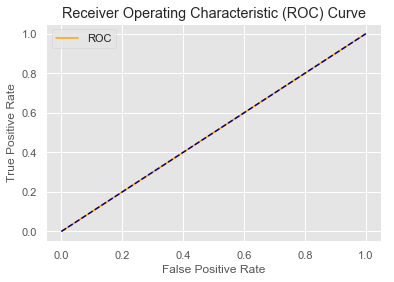

In [17]:
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score  

# Get AUC score

def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
dummy_probs = dummy.predict_proba(X_test)  

dummy_probs = dummy_probs[:, 1]  

auc = roc_auc_score(y_test, dummy_probs)  
print('AUC: %.2f' % auc) 

fpr, tpr, thresholds = roc_curve(y_test, dummy_probs)      
    
plot_roc_curve(fpr, tpr)  



### NEW FEATURES

#### The new features haven't helped the model, which was expected for some. Using the new features for visualizations

In [18]:
df2 = df.copy()

In [19]:
# Extra time for passengers in the plane or during onboarding

df2['extra_seat_time'] = df2['ArrDelay'] + df2['DepDelay']

In [20]:
df2['day_part'] = df2['Hour']

def hour_segment(x):
    '''
    Breaks hours into categories of day times
    
    INPUT:
        Time of day in hour format
        
    OUTPUT:
        Morning, afternoon, evening or night
    '''
    if x > 6 and x < 12:
        x = 'morning'
    elif x > 11 and x < 17:
        x = 'afternoon'
    elif x > 16 and x < 21: 
        x = 'evening'
    else:
        x = 'night'
    return x

df2['day_part'] = df2['day_part'].apply(hour_segment)
df2['Hour'] = df2['Hour'].astype(str)



# Noon is at 12:00 PM. Afternoon is from 12:01 PM to around 5:00 PM. Evening is from 5:01 PM to 8 PM, 
#                 or around sunset. Night is from sunset to sunrise, so from 8:01 PM until 5:59 AM.

In [21]:
# Breaking the month down into seasons

df2['Month'] = df2['Month'].astype(int)
df2['Season'] = df2['Month'].copy()

def season(x):
    '''
    Month to season conversion
    
    INPUT:
        Month number
    
    OUTPUT:
        Season name - categorical
    '''
    if x in [12,1,2]:
        x = 'winter'
    elif x in [3,4,5]:
        x = 'spring'
    elif x in [6,7,8]:
        x = 'summer'
    else:
        x = 'fall'
    return x

df2['Season'] = df2['Season'].apply(season)      
df2['Month'] = df2['Month'].astype(str)

In [22]:
df2['Flight_Length'] = df2['Distance'].copy()

def flight_category(x):
    '''
    Converts flight length to flight type. Numerical to categorical conversion
    
    INPUT:
        Flight length in miles
        
    OUTPUT:
        Flight length as category
    '''
    if x < 1500:
        x = 'short haul'
    elif x > 5000:
        x = 'long haul'
    else:
        x = 'medium haul'
    return x

df2['Flight_Length'] = df2['Flight_Length'].apply(flight_category)      


In [23]:
# Creating a new average speed column based on distance and scheduled flight duration.
df2['avg_speed'] = df2['Distance'] / df2['SchedElapsedTime'] * 60

In [24]:
df2['avg_speed'].describe()

count    5979.000000
mean      339.540193
std        96.306938
min        85.000000
25%       290.727273
50%       344.594595
75%       392.269697
max      3807.142857
Name: avg_speed, dtype: float64

In [25]:
df2.sort_values(by=['avg_speed'], ascending = False).head(5)

,Canceled,Month,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,Hour,extra_seat_time,day_part,Season,Flight_Length,avg_speed
234,1.0,4,DL,252.0,0.0,0,15990.0,16,0.0,afternoon,spring,long haul,3807.142857
5994,0.0,12,AA,185.0,20.0,22,10170.0,7,42.0,morning,winter,long haul,3298.378378
1263,0.0,7,AA,70.0,0.0,-1,762.0,14,-1.0,afternoon,summer,short haul,653.142857
3645,0.0,10,UA,470.0,-31.0,-4,4213.0,16,-35.0,afternoon,fall,medium haul,537.829787
1207,0.0,5,UA,481.0,-15.0,-8,4243.0,16,-23.0,afternoon,spring,medium haul,529.272349


Here we see there are 2 flights that fly faster than speed of sound, which is not plausible unless we were working on a NASA R&D dataset.. No passenger plane flies near those speeds, so we're going to drop those top 2 flights from our dataset

In [26]:
df2 = df2.drop([234, 5994])

In [27]:
def plane_type(x):
    '''
    Function to convert average speed to plane type
    
    INPUT:
        Average speed of plane
    
    OUTPUT:
        Plane type
    '''
    if x > 450:
        x = 'turbo prop'
    elif x < 250:
        x = 'single prop'
    else:
        x = 'multi engine prop'
    return x

df2['Aircraft'] = df2['avg_speed'].apply(plane_type)  

### EDA

#### Flight Status Distribution

[Text(0, 0.5, 'Count \n '), Text(0.5, 0, '\n Flight Status')]

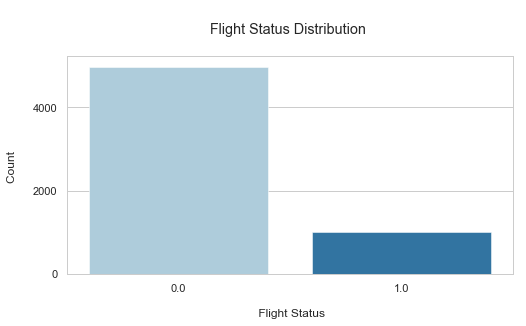

In [28]:
sns.set_palette("Paired")
sns.set_style("whitegrid")
plt.figure(figsize=(8,4))
ax = sns.countplot(df2['Canceled'])
ax.set_title(' \n Flight Status Distribution  \n')
sns.set(font_scale = 2)
ax.set(xlabel = '\n Flight Status', ylabel = 'Count \n ')

Visualization of the imbalance in our dataset.  

Canceled Flights: 1000 records  
Not Canceled Flights: 5000 records

#### Delays per Flight

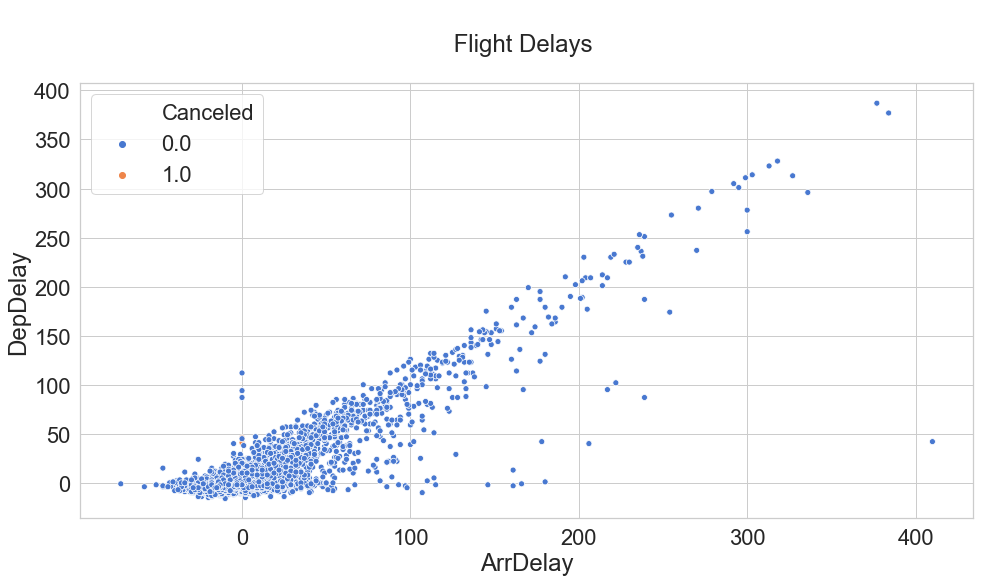

In [29]:
# Plotting Arr vs Dep Delays.. A plane that's cancelled shouldn't have delays.

sns.set_palette("muted")
sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
ax = sns.scatterplot(x=df2["ArrDelay"], y=df2["DepDelay"], hue="Canceled", data=df)
ax.set_title(' \n Flight Delays  \n')
sns.set(font_scale = 2)

In [30]:
# Removing rows with canceled status & with arrival delay

df2[(df2['Canceled'] == 1) & (df2['ArrDelay'] > 0)]

,Canceled,Month,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,Hour,extra_seat_time,day_part,Season,Flight_Length,avg_speed,Aircraft


In [31]:
# Removing rows with canceled status & with departure delay

df2[(df2['Canceled'] == 1) & (df2['DepDelay'] > 0)]

,Canceled,Month,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,Hour,extra_seat_time,day_part,Season,Flight_Length,avg_speed,Aircraft
48,1.0,12,UA,187.0,0.0,46,1197.0,18,46.0,evening,winter,short haul,384.064171,multi engine prop
307,1.0,12,DL,57.0,0.0,13,215.0,22,13.0,night,winter,short haul,226.315789,single prop
409,1.0,10,UA,281.0,0.0,14,1619.0,7,14.0,morning,fall,medium haul,345.693950,multi engine prop
540,1.0,12,AA,60.0,0.0,3,190.0,14,3.0,afternoon,winter,short haul,190.000000,single prop
550,1.0,12,DL,158.0,0.0,41,950.0,10,41.0,morning,winter,short haul,360.759494,multi engine prop


As one can imagine, a cancelled flight would not have an arrival or departure delay, 
unless the flight was cancelled after the scheduled departure time. Holding the 2 columns, 
initial model's AUC were all very close to 1.0, and that didn't look normal. 
I will be dropping off the 2 delay columns before modeling.

#### Total Number of Cancellations per Carrier

[Text(0, 0.5, 'Count \n '), Text(0.5, 0, '\n Carrier')]

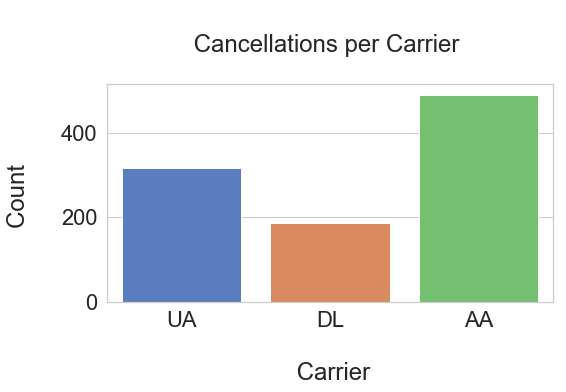

In [32]:
# Total Cancellations per airline
sns.set_palette("muted")
sns.set_style("whitegrid")
plt.figure(figsize=(8,4))
ax = sns.countplot(x = 'UniqueCarrier', data = df2.loc[df2['Canceled']==1])
ax.set_title(' \n Cancellations per Carrier  \n')
sns.set(font_scale = 2)
ax.set(xlabel = '\n Carrier', ylabel = 'Count \n ')



American Airlines had the highest number of cancelations and Delta had the lowest.

#### Number of Cancellations per Carrier per Month

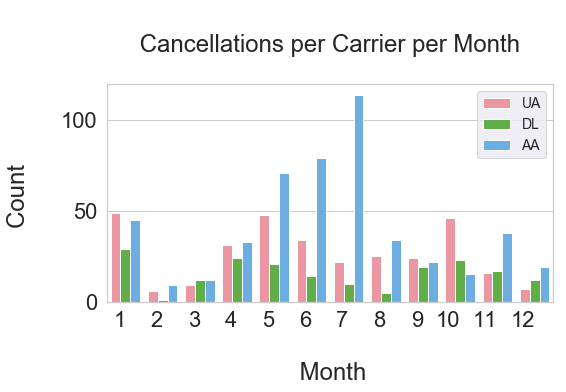

In [33]:
sns.set_palette("RdBu_r", 2)
sns.set_style("whitegrid")
# plot data
plt.figure(figsize=(8,4))
ax = sns.countplot(x = 'Month', data = df2.loc[df['Canceled'] == 1], hue='UniqueCarrier')
ax.set_title(' \n Cancellations per Carrier per Month \n')
sns.set(font_scale = 2)
ax.set(xlabel = '\n Month', ylabel = 'Count \n ')
# loc, labels = plt.xticks()
# ax.set_xticklabels(labels, rotation=90)
plt.legend(loc='upper right')
ax.legend(fontsize = 'xx-small')

df2['Month'] = df2['Month'].astype(int)
dates = df2['Month'].sort_values(ascending = True).unique()
ax.set_xticklabels(labels = dates , ha='right')
df2['Month'] = df2['Month'].astype(str)

In [34]:
df2.groupby(['UniqueCarrier', 'Month'])['Canceled'].mean()

UniqueCarrier  Month
AA             1        0.215311
               10       0.053254
               11       0.067416
               12       0.206250
               2        0.311404
               3        0.344978
               4        0.358491
               5        0.169154
               6        0.114583
               7        0.088757
               8        0.158996
               9        0.107345
DL             1        0.207143
               10       0.007143
               11       0.098361
               12       0.143713
               2        0.133758
               3        0.106061
               4        0.078125
               5        0.035971
               6        0.139706
               7        0.181102
               8        0.117241
               9        0.083333
UA             1        0.266304
               10       0.042553
               11       0.073171
               12       0.233083
               2        0.258065
               3      

#### Worst Month to Fly:  

AA: April  
DL: January  
UA: January  

#### Number of Cancellations per Carrier per Hour of the Day

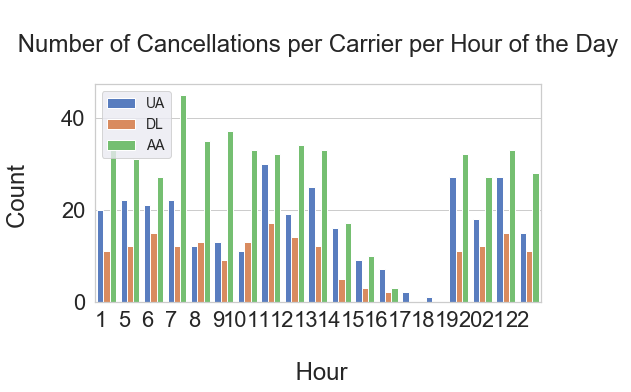

In [35]:
sns.set_palette("muted")
sns.set_style("whitegrid")
# plot data
plt.figure(figsize=(8,4))
ax = sns.countplot(x = 'Hour', data = df2.loc[df2['Canceled'] == 1], hue='UniqueCarrier')
ax.set_title(' \n Number of Cancellations per Carrier per Hour of the Day \n')
sns.set(font_scale = 2)
ax.set(xlabel = '\n Hour', ylabel = 'Count \n ')
# loc, labels = plt.xticks()
# ax.set_xticklabels(labels, rotation=90)
plt.legend(loc='upper right')
ax.legend(fontsize = 'xx-small')

df2['Hour'] = df2['Hour'].astype(int)
dates = df2['Hour'].sort_values(ascending = True).unique()
ax.set_xticklabels(labels = dates , ha='right')
df2['Hour'] = df2['Hour'].astype(str)

In [36]:
df2.groupby(['UniqueCarrier', 'Hour'])['Canceled'].mean()

UniqueCarrier  Hour
AA             1       0.000000
               10      0.203593
               11      0.203947
               12      0.168750
               13      0.264706
               14      0.210843
               15      0.201087
               16      0.191860
               17      0.200000
               18      0.204819
               19      0.234043
               20      0.195402
               21      0.192308
               22      0.115385
               23      0.000000
               5       0.000000
               6       0.195122
               7       0.195652
               8       0.168367
               9       0.183007
DL             10      0.100917
               11      0.096000
               12      0.137615
               13      0.113208
               14      0.138298
               15      0.085714
               16      0.098485
               17      0.149123
               18      0.134615
               19      0.181818
               20   

#### Worst Hour to Fly:  

AA: 1pm  
DL: 7pm     
UA: 5am   

#### Total Delays per Carrier

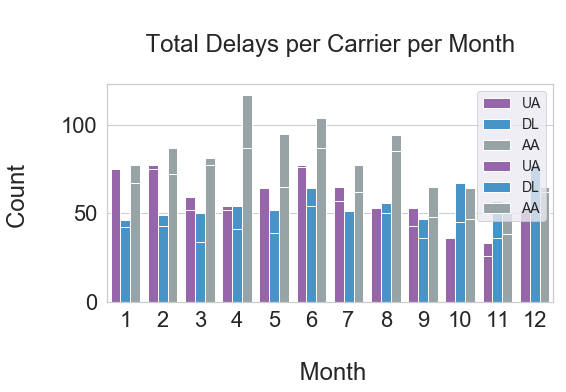

In [37]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
sns.set_style("whitegrid")
# plot data
df2['Month'] = df2['Month'].astype(int)

plt.figure(figsize=(8,4))
ax = sns.countplot(x = 'Month', data = df2.loc[df['ArrDelay'] > 0], hue='UniqueCarrier')
ax = sns.countplot(x = 'Month', data = df2.loc[df['DepDelay'] > 0], hue='UniqueCarrier')
ax.set_title(' \n Total Delays per Carrier per Month \n')
sns.set(font_scale = 2)
ax.set(xlabel = '\n Month', ylabel = 'Count \n ')
plt.legend(loc='upper right')
ax.legend(fontsize = 'xx-small')

#### Flight Durations

Text(0.5, 1.0, 'Distribution of Flight Duration')

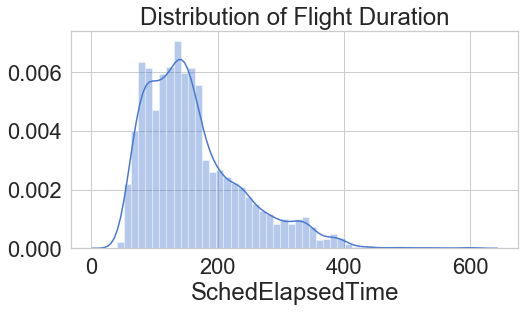

In [38]:
sns.set_palette("muted")
sns.set_style("whitegrid")
plt.figure(figsize=(8,4))
ax = sns.distplot(df2['SchedElapsedTime'])
ax.set_title('Distribution of Flight Duration')

### Time of Day Cancellations Breakdown

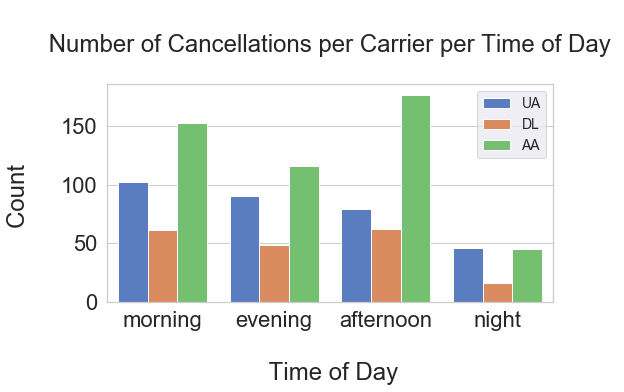

In [39]:
sns.set_palette("muted")
sns.set_style("whitegrid")
# plot data
plt.figure(figsize=(8,4))
ax = sns.countplot(x = 'day_part', data = df2.loc[df['Canceled'] == 1], hue='UniqueCarrier')
ax.set_title(' \n Number of Cancellations per Carrier per Time of Day \n')
sns.set(font_scale = 2)
ax.set(xlabel = '\n Time of Day', ylabel = 'Count \n ')
# loc, labels = plt.xticks()
# ax.set_xticklabels(labels, rotation=90)
plt.legend(loc='upper right')
ax.legend(fontsize = 'xx-small')


### Percentage of Flights Canceled per Carrier per Time of Day

In [40]:
pd.crosstab(df2['day_part'], df2['UniqueCarrier'], values=df2["Canceled"], aggfunc='mean')

UniqueCarrier,AA,DL,UA
day_part,,,
afternoon,0.207746,0.113553,0.149057
evening,0.209386,0.138728,0.206897
morning,0.189826,0.102007,0.172007
night,0.175097,0.085561,0.168498


From the above table, we're seeing that American Airlines have a cancelation rate of ~20% for their afternoon and evening flights followed by ~19% for their morning flights and ~17% for their night flights.

### Cancellation by Seasons

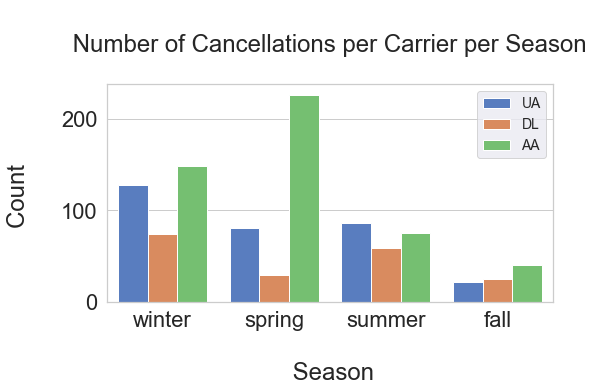

In [41]:
sns.set_palette("muted")
sns.set_style("whitegrid")
# plot data
plt.figure(figsize=(8,4))
ax = sns.countplot(x = 'Season', data = df2.loc[df['Canceled'] == 1], hue='UniqueCarrier')
ax.set_title(' \n Number of Cancellations per Carrier per Season \n')
sns.set(font_scale = 2)
ax.set(xlabel = '\n Season', ylabel = 'Count \n ')
# loc, labels = plt.xticks()
# ax.set_xticklabels(labels, rotation=90)
plt.legend(loc='upper right')
ax.legend(fontsize = 'xx-small')


### Percentage of Flights Canceled by Season per Carrier

In [42]:
pd.crosstab(df2['Season'],df2['UniqueCarrier'], values=df2["Canceled"], aggfunc='mean')

UniqueCarrier,AA,DL,UA
Season,,,
fall,0.076336,0.061576,0.055838
spring,0.303476,0.072682,0.174946
summer,0.125000,0.144608,0.182590
winter,0.249581,0.159483,0.254473


American Airlines cancel 30% of their Spring flights, whereas that Delta cancels only 7%, meaning flying with Delta will have a higher probability of getting where a passenger needs to go on time during Spring

### Cancellation by Distance

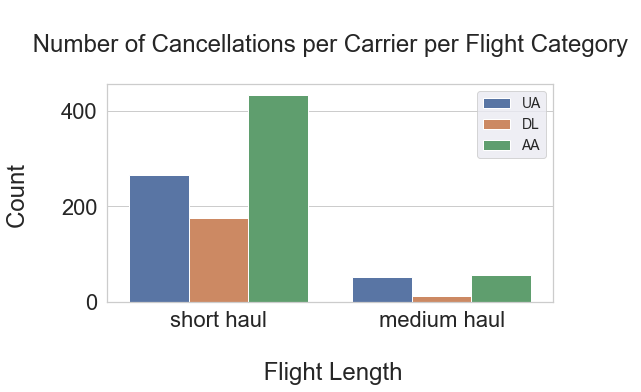

In [43]:
sns.set_style("whitegrid")
# plot data
plt.figure(figsize=(8,4))
ax = sns.countplot(x = 'Flight_Length', data = df2.loc[df2['Canceled'] == 1], hue='UniqueCarrier')
ax.set_title(' \n Number of Cancellations per Carrier per Flight Category \n')
sns.set(font_scale = 2)
ax.set(xlabel = '\n Flight Length', ylabel = 'Count \n ')
# loc, labels = plt.xticks()
# ax.set_xticklabels(labels, rotation=90)
plt.legend(loc='upper right')
ax.legend(fontsize = 'xx-small')


Most of the flight cancelations has been on short haul flights, where we see Delta again with the lowest number of cancelations.

### Percentage of Flights Canceled by Distance per Carrier

In [44]:
pd.crosstab(df2['Flight_Length'],df2['UniqueCarrier'], values=df2["Canceled"], aggfunc='mean')

UniqueCarrier,AA,DL,UA
Flight_Length,,,
medium haul,0.152174,0.032738,0.113586
short haul,0.207044,0.131245,0.192475


Here we can see Delta is the best option when it comes to short & medium haul flights with lowest rate of cancellation. Delta canceled only 3% of their medium haul flights and 13% of short haul flights.

### Worst 20 times to fly

In [45]:
df2.groupby(['UniqueCarrier', 'Month', 'Flight_Length'])['Canceled'].mean().sort_values(ascending = False).head(20)

UniqueCarrier  Month  Flight_Length
AA             3      short haul       0.368159
               4      short haul       0.361940
               2      short haul       0.340314
               4      medium haul      0.340000
UA             7      short haul       0.296296
               1      medium haul      0.288889
               2      short haul       0.285714
AA             1      medium haul      0.269231
UA             1      short haul       0.258993
               3      short haul       0.258621
DL             1      short haul       0.243243
UA             12     short haul       0.240385
AA             12     medium haul      0.233333
DL             7      short haul       0.224490
AA             1      short haul       0.207650
UA             12     medium haul      0.206897
AA             12     short haul       0.200000
UA             5      short haul       0.183206
               4      short haul       0.181818
AA             3      medium haul      0.178571
Name

From the table above, we're seeing the worst 20 times to fly based on cancelation numbers. For example, Flying with American Airlines in March & April on a short haul flight had a cancelation rate of ~37%.

### Airlines based on total cancelations.

In [46]:
# Creating table of flight status for each airline

pd.crosstab(df2['Canceled'],df2['UniqueCarrier']).apply(lambda x: x/x.sum(), axis=0)


UniqueCarrier,AA,DL,UA
Canceled,,,
0.0,0.801134,0.888491,0.826871
1.0,0.198866,0.111509,0.173129


---------------------

## MOST RELIABLE AIRLINE

#### As we can see from the visualizations and the tables above, from a total cancelations perspective, Delta airlines is the most reliable out of 3 with only 11% of the flights getting cancelled.  

For more personalized flight recommendations, it's advisable to take the flight month, time and distance into consideration when making a ticket sale.

Focusing ticket sales efforts on Delta Airlines which will produce the least amount of cancelations, pending required departure/arrival times of flights, except when the flight is in Fall season where United Airlines has a lower cancelation rate.

Using this model, one can (at a basic level, with min amount of information) make predictions around whether a flight will be canceled or not depending on the month, day, time and distance. 


In [47]:
df['Month'] = df['Month'].astype(str)

In [48]:
# removing features that create data leakage
df = df.drop(['ArrDelay', 'DepDelay'], axis = 1)

In [49]:
df.sample()

,Canceled,Month,UniqueCarrier,SchedElapsedTime,Distance,Hour
4122,0.0,11,AA,175.0,929.0,14


### Feature Selection

In [50]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [51]:
X = df.drop('Canceled', axis = 1)
y = df['Canceled']

X = pd.get_dummies(X)

In [52]:
X.shape

(5979, 18)

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [56]:
# Benchmark Model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_valid, y_valid)))

R^2 Training Score: 0.99 
OOB Score: 0.81 
R^2 Validation Score: 0.80


In [57]:
from sklearn.base import clone 

# negative importance, means that removing a given feature from the model actually improves the performance. 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

drop_imp = drop_col_feat_imp(rf, X_train, y_train)
# var_imp_plot(drop_imp, 'Drop Column feature importance')   

In [58]:
drop_imp

,feature,feature_importance
0,Hour,0.018608
1,Distance,0.013172
2,SchedElapsedTime,0.006481
3,UniqueCarrier_DL,0.000209
4,UniqueCarrier_AA,0.000209
5,Month_9,0.000209
6,Month_7,0.000209
7,Month_6,0.000209
8,Month_5,0.000209
9,UniqueCarrier_UA,0.000209


### DROP UNIMPORTANT FEATURES

In [59]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

In [61]:
X = X.drop(X[to_drop], axis=1)


In [62]:
X.shape

(5979, 17)

In [63]:
to_drop

['Distance']

---------------

### Modeling

In [64]:
# Splitting the data to train & test on a 80:20 split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(f"Original data shapes: {X_train.shape, X_test.shape}")



Original data shapes: ((4783, 17), (1196, 17))


#### Logistic Regression



After using a ensemble & boosting model, now I'll be building a logistic regression model. Logistic regression is intrinsically simple, very fast and it has low variance and so is less prone to over-fitting.

In [65]:
# Grid search for Logistic regression
lr = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
grid_lr = GridSearchCV(lr, param_grid = grid_values, scoring = 'roc_auc')

best_model = grid_lr.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 100


In [66]:
logistic = LogisticRegression(penalty = 'l1',
                              class_weight = 'balanced', 
                              C = 100,
                              random_state = 123, 
                              fit_intercept=True)

pip_baseline = make_pipeline(RobustScaler(), logistic)


logistic.fit(X_train,y_train)

logistic_predictions = logistic.predict(X_test)
logistic_prob = logistic.predict_proba(X_test)

scores_log = cross_val_score(logistic,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)


print("\n========================================================")
print(" Results from Logistic Regression " )
print("========================================================")  
print("\n")
print(f"Logistic Regression model's average CV score: {scores_log.mean():.3f}")
print("\n")
print(classification_report(y_test, logistic_predictions))
print("\n========================================================")
print("\n")
print(f"Logistic Regression's Accuracy Score is: {accuracy_score(y_test, logistic_predictions)}")
print(f"Logistic Regression's Precision Score is {precision_score(y_test, logistic_predictions, average='weighted')}")
print("\n")




 Results from Logistic Regression 


Logistic Regression model's average CV score: 0.666


              precision    recall  f1-score   support

         0.0       0.90      0.57      0.70       985
         1.0       0.26      0.70      0.38       211

   micro avg       0.59      0.59      0.59      1196
   macro avg       0.58      0.64      0.54      1196
weighted avg       0.79      0.59      0.64      1196




Logistic Regression's Accuracy Score is: 0.5936454849498328
Logistic Regression's Precision Score is 0.7862893123019522




AUC: 0.69


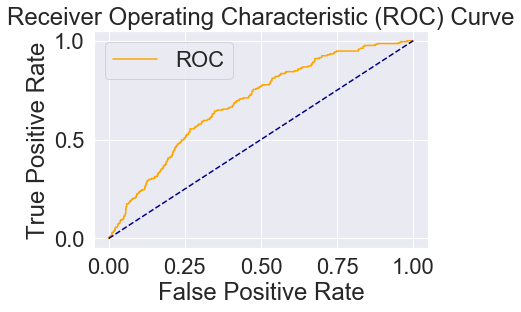

In [67]:
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score  

probs = logistic_prob[:, 1]

auc = roc_auc_score(y_test, probs)  
print('AUC: %.2f' % auc) 

fpr, tpr, thresholds = roc_curve(y_test, probs)  

def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
plot_roc_curve(fpr, tpr)  


Average precision-recall score: 0.29


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.29')

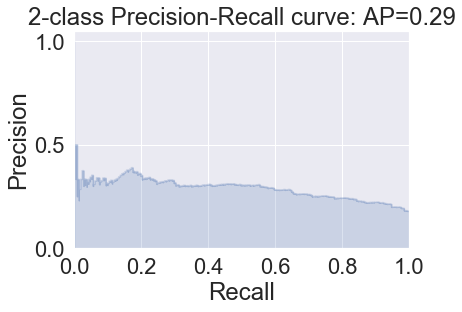

In [68]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import average_precision_score




y_score = logistic.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

<Figure size 1152x576 with 0 Axes>

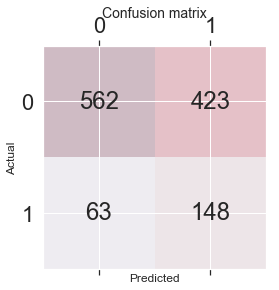

In [69]:
# Logistic Reg. Confusion Matrix
y_pred = logistic_predictions
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap = plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x = j, y = i, s = conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 14})
plt.xlabel("Predicted", fontdict={"fontsize": 12})
plt.ylabel("Actual", fontdict={"fontsize": 12});

#### Random Forest

Random Forest is known to perform well with binary classification problems.  
  
In learning extremely imbalanced data, there is a significant probability that a bootstrap sample
contains few or even none of the minority class, resulting in a tree with poor performance for predicting
the minority class.  

Balanced Random Forest ensembles trees induced from balanced down-sampled data

In [70]:
# # Grid Search 
# # Computationally expensive.. Using optimized parameters.

# rfc = RandomForestClassifier(random_state=123)
# rfc.fit(X_train,y_train)

# param_grid = { 
#     'n_estimators': [200, 500, 1000],
#     'max_depth' : [1,2,3],
#     'criterion' :['gini', 'entropy'],
#     'max_features' :[0.50, 1, 2, 3]
# }

# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }


# CV_rfc = GridSearchCV(estimator = rfc, scoring=scorers, param_grid = param_grid, cv = 10, refit = False)

# CV_rfc.fit(X_train, y_train)
# CV_rfc.get_params()


In [71]:
# Random Forest Classifier Model

brf = BalancedRandomForestClassifier(n_estimators = 1000,
                                     random_state = 123,
                                     criterion = 'gini',
                                     max_features = 'auto',
                                     max_depth = None,
                                     class_weight = 'balanced_subsample'
                                    )

pip_baseline = make_pipeline(RobustScaler(), brf)
brf_scores = cross_val_score(pip_baseline,
                         X_train, y_train,
                         scoring = "roc_auc", cv = 10)

brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)

brf_probs = brf.predict_proba(X_test)  

print("\n========================================================")
print(" Results from Balanced RF Model" )
print("========================================================")
print("\n")
print(f"Balanced RF Model's CV Score: {brf_scores.mean():.3f}")
print("\n")
print(classification_report(y_test, y_pred_brf))
print("\n========================================================")

print("\n")
print(f"RF Model's Accuracy Score is: {accuracy_score(y_test, y_pred_brf)}")
print(f"RF Model's Precision Score is {precision_score(y_test, y_pred_brf, average='weighted')}")
print("\n")



 Results from Balanced RF Model


Balanced RF Model's CV Score: 0.663


              precision    recall  f1-score   support

         0.0       0.89      0.62      0.73       985
         1.0       0.26      0.63      0.37       211

   micro avg       0.62      0.62      0.62      1196
   macro avg       0.57      0.62      0.55      1196
weighted avg       0.78      0.62      0.66      1196




RF Model's Accuracy Score is: 0.6195652173913043
RF Model's Precision Score is 0.7759434829832554




AUC: 0.66


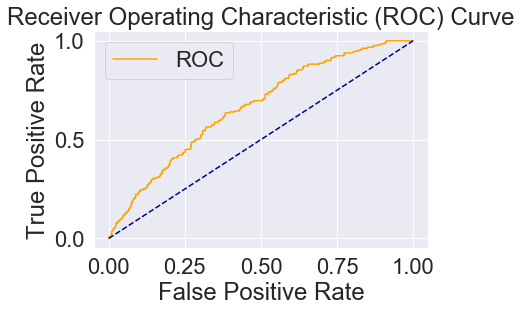

In [72]:
brf_probs = brf_probs[:, 1]  

auc = roc_auc_score(y_test, brf_probs)  
print('AUC: %.2f' % auc) 

fpr, tpr, thresholds = roc_curve(y_test, brf_probs)      
    
plot_roc_curve(fpr, tpr)  


<Figure size 576x288 with 0 Axes>

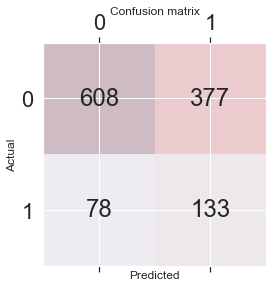

In [73]:
# Random Forest Confusion Matrix

conf_mat = confusion_matrix(y_test, y_pred_brf)
plt.figure(figsize=(8, 4))
plt.matshow(conf_mat, cmap = plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x = j, y = i, s = conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 12})
plt.xlabel("Predicted", fontdict={"fontsize": 12})
plt.ylabel("Actual", fontdict={"fontsize": 12});

In [74]:
# Plot features importance

importances = brf.feature_importances_
indices = np.argsort(brf.feature_importances_)[::-1]
# plt.figure(figsize = (14, 10))
# plt.barh(df_merged.columns[df_merged.columns != "WasTheLoanApproved"][indices], importances[indices], alpha=0.5, )
# plt.title('RF Feature Importance')

feat_imp = pd.Series(importances[indices], X.columns[X.columns != "Canceled"][indices])

print("\n========================================================")
print("Feature Importance" )
print("========================================================")
print("\n")


print(feat_imp)


Feature Importance


SchedElapsedTime    0.419392
Hour                0.287737
Month_10            0.036732
UniqueCarrier_DL    0.025549
Month_4             0.023890
UniqueCarrier_AA    0.023862
Month_9             0.019422
UniqueCarrier_UA    0.019392
Month_11            0.018876
Month_2             0.018702
Month_1             0.018359
Month_3             0.017751
Month_7             0.016160
Month_5             0.014438
Month_12            0.014262
Month_8             0.012861
Month_6             0.012615
dtype: float64


### Tester Function

In [ ]:
# This is a simple function that let's a user feed a flight data and get cancelation prediction

import pickle
pickled_model = pickle.dumps(model)

In [ ]:
def cancel_predict(df):
    # Load pickled logistic model
    clf = pickle.loads(pickled_model)

    # Predictions
    y_pred = clf.predict(df)    
    return y_pred

In [ ]:
cancel_predict(S_test)